In [56]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY
import warnings
warnings.filterwarnings('ignore')


# Load in Asset Data

In [8]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF

}

start_date = '2010-01-01'


In [48]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
else:
    print("No data was fetched. Please check ticker symbols and API key.")


Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-12 00:00:00


In [57]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('M').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [77]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")
standardized_monthly_returns = standardized_monthly_returns[standardized_monthly_returns.index <= '2025-05-12']

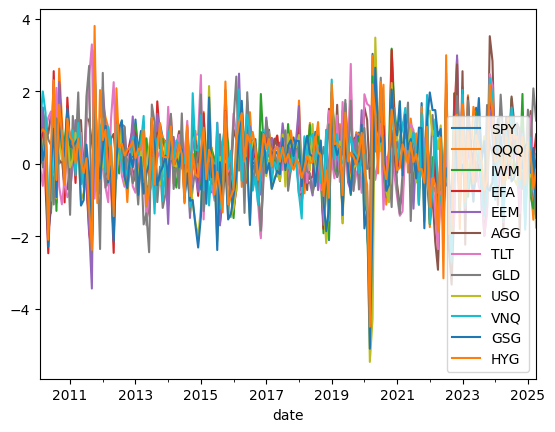

In [79]:
standardized_monthly_returns.plot()
plt.show()

# Load in Macro Data

In [74]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'PX_Last'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed
           .resample('M').mean()   # month-end average
            #.asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])     # trim to asset window
# select only >2010 to 2025 April
fed = fed[(fed.index >= '2010-02-01') & (fed.index <= '2025-05-12')]

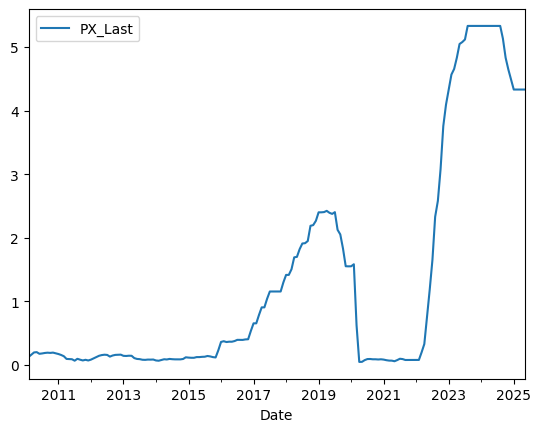

In [61]:
fed.plot()
plt.show()

In [144]:
FILE1             = "../data/Assignment_2_data.xlsm"

ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism.rename(columns={'ISM': 'PMI'}, inplace=True)
ism = ism[~ism.index.duplicated(keep='last')]

ism = (ism            # daily EFFR
           .resample('M').mean()      # calendar‑month mean
            #.asfreq('B', method='ffill')  # fill forward to biz days
           [ism.index.min():])   # trim to asset window
ism['pct_change'] = ism['PMI'].pct_change()
ism = ism.dropna()
ism = ism['pct_change']
# select only >2010
ism = ism[(ism.index >= '2010-02-01') & (ism.index <= '2025-05-12')]

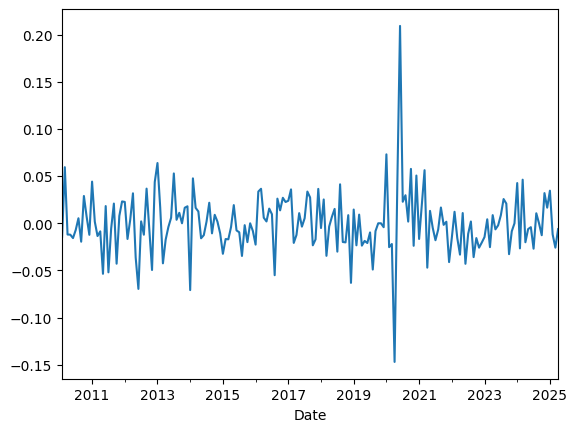

In [145]:
ism.plot()
plt.show()

<small>
3.

We selected the Federal Funds Rate and the ISM Purchasing Managers’ Index (PMI) to represent our macroeconomic factors because over 50% of our asset universe is concentrated in the United States. Therefore, it is appropriate to focus on indicators that directly reflect the U.S. economy.

The Federal Funds Rate serves as a key signal of the Federal Reserve’s economic outlook. It influences a wide range of macro assets—including equities, bonds, and commodities by impacting the cost of borrowing. When the Fed raises interest rates, it typically aims to combat inflation or cool down an overheating economy, which can lead to declines in equity prices and bond prices due to rising yields. Conversely, rate cuts are often intended to stimulate economic activity by making borrowing cheaper. In many periods, the Fed holds rates steady to wait for clearer economic signals before taking action.

The ISM PMI provides insights into business conditions from a supply chain perspective. It reflects trends in supply and demand and serves as a leading indicator of economic growth. A strong PMI suggests expansion in manufacturing and economic activity, while a decline may point to a slowdown.

Both indicators are forward-looking and reveal what the market expects to happen.

In [146]:
standardized_monthly_returns

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-02-28,0.745494,0.918217,0.779675,0.058758,0.341113,0.152639,-0.084683,0.721674,0.879064,1.095416,0.992750,0.836951
2010-03-31,1.455437,1.538245,1.435168,1.406441,1.558739,-0.005488,-0.606517,-0.096663,0.373072,1.998251,0.102940,0.954997
2010-04-30,0.369705,0.446223,0.988647,-0.617732,-0.033051,0.747155,0.927818,1.296535,0.254312,1.402865,0.527715,0.862332
2010-05-31,-1.898812,-1.473426,-1.313064,-2.465311,-1.803819,0.830953,1.275336,0.672612,-1.738013,-1.046650,-2.281427,-2.092834
2010-06-30,-1.236628,-1.228528,-1.350401,-0.456787,-0.269088,1.356995,1.446650,0.518853,-0.022866,-1.018884,0.012084,0.498899
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,-0.653226,0.058299,-1.506192,-0.937152,-0.639202,-1.543532,-1.683584,-0.310470,0.542068,-1.814891,0.500042,-0.577849
2025-01-31,0.641817,0.431479,0.435245,1.057452,0.413257,0.396079,0.122914,1.495349,0.322102,0.323770,0.578061,0.609019
2025-02-28,-0.303382,-0.539193,-0.910046,0.650436,0.220255,1.457968,1.328366,0.401433,-0.353576,0.725864,-0.245876,0.230230


In [147]:
fed

,PX_Last
Date,
2010-02-28,0.126316
2010-03-31,0.161739
2010-04-30,0.197727
2010-05-31,0.202500
2010-06-30,0.176364
...,...
2024-12-31,4.484762
2025-01-31,4.330000
2025-02-28,4.330000


In [148]:
ism

Date
2010-02-28   -0.014210
2010-03-31    0.059459
2010-04-30   -0.011905
2010-05-31   -0.012048
2010-06-30   -0.015679
                ...   
2024-12-31    0.016529
2025-01-31    0.034553
2025-02-28   -0.011788
2025-03-31   -0.025845
2025-04-30   -0.006122
Freq: ME, Name: pct_change, Length: 183, dtype: float64

In [172]:
from statsmodels.api import OLS
import statsmodels.api as sm

def collect_betas(y, x = standardized_monthly_returns, show=False):
    betas_dict = {}
    X = sm.add_constant(x)
    for col in x.columns:
        model = sm.OLS(y, x[col]).fit()
        results = model.summary()
        if show:
            print(results)

        betas_dict[col] = model.params[col]

    betas_df = pd.DataFrame(index = betas_dict.keys(), data = betas_dict.values())
    betas_df.rename(columns = {0:'Betas'}, inplace = True)
    return betas_df







In [174]:
betas_fed = collect_betas(fed, standardized_monthly_returns, show=False)

In [175]:
betas_fed

,Betas
SPY,0.339918
QQQ,0.384741
IWM,0.114261
EFA,0.229798
EEM,0.118327
AGG,0.251771
TLT,0.044492
GLD,0.436484
USO,-0.040663
VNQ,0.115476


In [176]:
betas_ism = collect_betas(ism, standardized_monthly_returns)

In [177]:
betas_ism

,Betas
SPY,0.002978
QQQ,0.003097
IWM,0.003850
EFA,0.002561
EEM,0.002666
AGG,-0.001841
TLT,-0.004035
GLD,-0.002604
USO,0.007124
VNQ,0.000748
